In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')
import os
from utils import *
from networkx.algorithms import *
from student_utils_sp18 import *
from networkx.algorithms.traversal import *
from networkx.algorithms.approximation import *
from vasilis_solver import *
from tqdm import tqdm
from vasilis_greedy_anneal import *
import matplotlib.pyplot as plt
from anneal import *
import re
%matplotlib inline

In [2]:
indirectory = "inputs/"
input_files = os.listdir(indirectory)

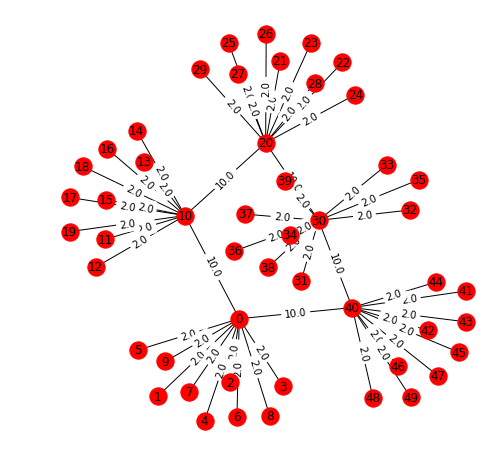

In [7]:
# 65, 66, 67
input_data = read_file(indirectory+"65.in")
number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix = data_parser(input_data)
            
G, start_index = get_G(number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix)

draw_graph(G)

In [8]:
t, c = vasilis_greedy_anneal_solver(G, start_index)
a1, a2 = cost_of_solution(G, t, c)
print(a2)

The conquering cost of your solution is 75.0
The travelling cost of your solution is 50.0
The total cost of your solution is 125.0


In [9]:
def ensemble(G, start_index):
    t, c = vasilis_solver(G.copy(), start_index)
    c1, a2 = cost_of_solution(G, t, c)
    
    tprime, cprime = vasilis_greedy_anneal_solver(G, start_index)
    c2, a2prime = cost_of_solution(G, tprime, cprime)
        
    if c1<c2:
        return t, c
    else:
        return tprime, cprime

In [ ]:
import shutil

shutil.rmtree('outputs/')
os.makedirs("outputs/")
solution_data_anneal  = solve_all(ensemble)

  0%|          | 2/716 [00:38<3:51:51, 19.48s/it]

In [3]:
def solve_all(solver):
    indirectory = "inputs/"
    outdirectory = "outputs/"
    
    #os.makedirs(outdirectory)
    
    infiles = os.listdir(indirectory)
    
    solution_data = {}
    
    for input_file in tqdm(infiles):
            input_data = read_file(indirectory+input_file)
            number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix = data_parser(input_data)
            
            G, start_index = get_G(number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix)
            try: 
                closed_walk, conquered_kingdoms = solver(G, start_index)
            except KeyError as e:
                print(e)
                print("Error in input file: {}".format(input_file))
            
            
            # get the score of our solution
            score, text = cost_of_solution(G, closed_walk, conquered_kingdoms)
            
            try:
                conquering_cost = re.search('\d+(\.\d{1,100000})?', text.split("\n")[0]).group(0)
                travelling_cost = re.search('\d+(\.\d{1,100000})?', text.split("\n")[1]).group(0)
                total_cost = re.search('\d+(\.\d{1,100000})?', text.split("\n")[2]).group(0)
                
                solution_data[indirectory+input_file] = {"conquering_cost":conquering_cost, "travelling_cost":travelling_cost,
                                                    "total_cost":total_cost}
            except AttributeError:
                print(indirectory+input_file)
                print(text)
       
            closed_walk = [list_of_kingdom_names[i] for i in closed_walk]
            conquered_kingdoms = [list_of_kingdom_names[i] for i in conquered_kingdoms]
            

            output_file = outdirectory + input_file[:-3] +".out"
            write_data_to_file(output_file, closed_walk, ' ')
            write_to_file(output_file, '\n', append=True)
            write_data_to_file(output_file, conquered_kingdoms, ' ', append=True)
            
    return solution_data

In [4]:
def get_G(number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix):
    
    name2index = {}
    index2name = {}

    count = 0
    for name in list_of_kingdom_names:
        name2index[name] = count
        index2name[count] = name
        count += 1

    G = adjacency_matrix_to_graph(adjacency_matrix)
    
    color = {}

    for node in G.nodes():
            color[node] = "white"


    conquering_cost = {}
    for node in G.nodes():
        conquering_cost[node] = adjacency_matrix[node][node]

    nx.set_node_attributes(G, conquering_cost, "conquering_cost")
    nx.set_node_attributes(G, color, "color")
    
    return G, name2index[starting_kingdom]

In [5]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G,'weight')
    plt.figure(3,figsize=(8,8)) 
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    nx.draw(G, pos, with_labels=True)